# The sky diving problem
# 
# $$\frac{dv_x}{dt} = -\frac{b}{m}\sqrt{v_x^2 + v_y^2} \cdot v_x $$
# $$\frac{dv_y}{dt} = - g -\frac{b}{m}\sqrt{v_x^2 + v_y^2} \cdot v_y $$
# 
# $\vec{S} = (v_x, v_y)$. To solve ODEs in python, 
# 
# 1. define function that takes in $t$ and $\vec{S}$ and returns $d\vec{S}/dt$ 

# Jupyter Notebook: Driveline Vibration Analysis and Optimization

"""
**Author:** Dominik Mallwitz

**Description:**
This Jupyter Notebook provides a comprehensive example of **driveline vibration analysis**, including:
1. **Theoretical Background** (Torsional modeling, modal analysis, etc.)
2. **Step-by-Step Code** (Refactored for clarity)
3. **Sparse Solver Implementation** for larger DOF systems.
4. **Modal Superposition** for approximate response.
5. **Transient gear shift & road bump simulations** (optional).
6. **Damping & Stiffness Optimization** examples.
"""

# 

1. Theoretical Background

1.1 Torsional Vibration Model
For an N-DOF torsional system, each component has:
- Moment of inertia (J_i)
- Damping (c_i)
- Stiffness (k_i)
 
he dynamic stiffness for each DOF is:
K_d(w) = k - w^2 * m + j * w * c

1.2 Modal Analysis
We solve the generalized eigenvalue problem:
(K - lambda M) phi = 0
where lambda = w^2.

1.3 Frequency Domain Response
We often compute:
Z(w) = K - w^2 M + j w C
X = Z^-1 * F

1.4 Transient Response
We can use time-domain integration (solve_ivp) to see displacement & velocity over time.

1.5 Optimization Approaches
- Damping optimization
- Stiffness tuning
- Mass redistribution


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import eigh
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import unittest

In [4]:






"""
## 2. Refactored Code Cells
Below are the main functions, each in its own cell, to keep the Notebook modular.
"""

# ### 2.1 Dynamic Stiffness

def dynamic_stiffness(m, c, k, w):
    """Computes the dynamic stiffness: K_d(w) = k - w^2 * m + j * w * c"""
    return k - (w**2)*m + 1j*w*c

# ### 2.2 Frequency Sweep N-DOF Response (Sparse)

def compute_NDOF_response(N, masses, dampings, stiffnesses, w_vals):
    """Computes frequency response for an N-DOF mass-spring-damper system using a sparse approach."""
    X_vals = np.zeros((N, len(w_vals)), dtype=complex)

    # Convert unit velocity to displacement in freq. domain
    for idx, w in enumerate(w_vals):
        # Build dynamic stiffness matrix
        main_diag = np.zeros(N, dtype=complex)
        off_diag = np.zeros(N - 1, dtype=complex)
        
        for i in range(N):
            # Dynamic stiffness for DOF i
            Kd = dynamic_stiffness(masses[i], dampings[i], stiffnesses[i], w)
            main_diag[i] = Kd
            if i > 0:
                off_diag[i - 1] = -stiffnesses[i]  # Coupling to previous DOF

        # Construct the sparse matrix
        M_sparse = diags([
            off_diag, 
            main_diag, 
            off_diag
        ], offsets=[-1, 0, 1], format="csr")

        # Force vector (applied at DOF 0) for base velocity -> force eq
        #   F = -(j w c1 + k1) * X_base  [approx example if we want base excitations]
        #   Here, we just do a unit test example:
        #   let's apply unit force at DOF 0.
        RHS = np.zeros(N, dtype=complex)
        RHS[0] = 1.0  # unit force

        # Solve
        X_vals[:, idx] = spsolve(M_sparse, RHS)

    return X_vals

# ### 2.3 Modal Analysis (N-DOF)

def compute_modal_analysis(N, masses, dampings, stiffnesses):
    """Computes modal frequencies and mode shapes for an N-DOF system."""
    # Construct mass & stiffness matrices in a simple diagonal + off-diag format
    M_matrix = np.diag(masses)
    K_matrix = np.zeros((N, N), dtype=float)

    for i in range(N):
        K_matrix[i, i] += stiffnesses[i]
        if i > 0:
            K_matrix[i, i] += stiffnesses[i]
            K_matrix[i, i-1] = -stiffnesses[i]
            K_matrix[i-1, i] = -stiffnesses[i]

    # Solve the generalized eigenvalue problem: (K - lambda M) phi = 0
    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(M_matrix) @ K_matrix)
    
    # Sort eigenvalues
    idx = np.argsort(eigvals)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Convert eigenvalues to frequencies
    natural_frequencies = np.sqrt(np.abs(eigvals)) / (2 * np.pi)

    return natural_frequencies, eigvecs

# ### 2.4 Modal Superposition

def compute_modal_response(N, w_vals, natural_frequencies, mode_shapes, masses, stiffnesses):
    """Computes the modal response approximation using the dominant modes."""
    num_modes = N
    modal_contributions = np.zeros((N, len(w_vals)), dtype=complex)

    for i in range(num_modes):
        phi_i = mode_shapes[:, i]
        lambda_i = (2 * np.pi * natural_frequencies[i])**2
        for j, w in enumerate(w_vals):
            # Example: apply unit force at DOF 0.
            # q_i ~ (phi_i[0]) / (lambda_i - w^2)
            modal_contributions[:, j] += phi_i * (phi_i[0] / (lambda_i - w**2))

    # Reconstructed response at DOF 0
    reconstructed_response = modal_contributions[0, :]
    return reconstructed_response, modal_contributions

# ### 2.5 Time-Domain Simulation for Transients

def driveline_dynamics(t, y, J_values, C_values, K_values, torque_func):
    """State derivatives for time-domain simulation. y= [theta_i, omega_i]"""
    N = len(J_values)
    theta = y[:N]
    omega = y[N:]

    # Construct torque from stiffness & damping
    # For a chain system:
    T = np.zeros(N, dtype=float)

    # Example: simplest chain (N=4) with couplings
    # This is for demonstration; a general approach would be more complex

    # Add external torque
    T += torque_func(t)

    # alpha = T / J
    alpha = T / J_values

    return np.concatenate((omega, alpha))

# ---

In [7]:


"""
## 3. Example Analysis with a 4-DOF Driveline
We'll replicate your final example (4-DOF with correct mass coupling) and do a frequency sweep.
"""

# 3.1 System Setup
m1 = 1.0
c1 = 10.0
k1 = 2000.0
m2 = 1.0
c2 = 2.0
k2 = 12000.0
m3 = 1.5
c3 = 5.0
k3 = 3000.0
m4 = 0.8
c4 = 3.0
k4 = 3500.0

f_min = 0.1
f_max = 35.0
num_points = 1000
f_vals = np.linspace(f_min, f_max, num_points)
w_vals = 2 * np.pi * f_vals

# 3.2 Frequency-Domain 4-DOF Response

def compute_4DOF_response(m1, c1, k1,
                          m2, c2, k2,
                          m3, c3, k3,
                          m4, c4, k4,
                          w):
    # Compute dynamic stiffness terms
    Kd1 = dynamic_stiffness(m1, c1, k1, w)
    Kd2 = dynamic_stiffness(m2, c2, k2, w)
    Kd3 = dynamic_stiffness(m3, c3, k3, w)
    Kd4 = dynamic_stiffness(m4, c4, k4, w)

    V_base = 1.0
    X_base = V_base / (1j * w)

    M = np.array([
        [Kd1 + k2,    -k2,       0,        0],
        [   -k2, Kd2 + k3,   -k3,        0],
        [    0,     -k3, Kd3 + k4,     -k4],
        [    0,      0,       -k4,    Kd4]
    ])

    F_input = -(1j*w*c1 + k1) * X_base
    RHS = np.array([F_input, 0, 0, 0], dtype=complex)

    X1, X2, X3, X4 = np.linalg.solve(M, RHS)
    return X1, X2, X3, X4

X1_vals_4DOF = np.zeros_like(w_vals, dtype=complex)
X2_vals_4DOF = np.zeros_like(w_vals, dtype=complex)
X3_vals_4DOF = np.zeros_like(w_vals, dtype=complex)
X4_vals_4DOF = np.zeros_like(w_vals, dtype=complex)

for i, w in enumerate(w_vals):
    if w == 0:
        # Avoid division by zero.
        X1_vals_4DOF[i] = 0.0
        X2_vals_4DOF[i] = 0.0
        X3_vals_4DOF[i] = 0.0
        X4_vals_4DOF[i] = 0.0
    else:
        X1_vals_4DOF[i], X2_vals_4DOF[i], X3_vals_4DOF[i], X4_vals_4DOF[i] = (
            compute_4DOF_response(m1, c1, k1,
                                  m2, c2, k2,
                                  m3, c3, k3,
                                  m4, c4, k4, w)
        )

A1_vals_4DOF = -w_vals**2 * X1_vals_4DOF
A2_vals_4DOF = -w_vals**2 * X2_vals_4DOF
A3_vals_4DOF = -w_vals**2 * X3_vals_4DOF
A4_vals_4DOF = -w_vals**2 * X4_vals_4DOF

A1_mag_4DOF = np.abs(A1_vals_4DOF)
A2_mag_4DOF = np.abs(A2_vals_4DOF)
A3_mag_4DOF = np.abs(A3_vals_4DOF)
A4_mag_4DOF = np.abs(A4_vals_4DOF)



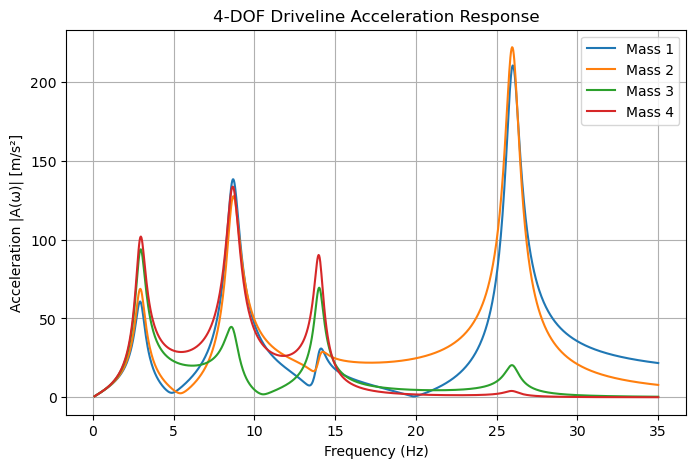

In [8]:
# Plot
plt.figure(figsize=(8,5))
plt.plot(f_vals, A1_mag_4DOF, label="Mass 1")
plt.plot(f_vals, A2_mag_4DOF, label="Mass 2")
plt.plot(f_vals, A3_mag_4DOF, label="Mass 3")
plt.plot(f_vals, A4_mag_4DOF, label="Mass 4")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Acceleration |A(ω)| [m/s²]")
plt.title("4-DOF Driveline Acceleration Response")
plt.legend()
plt.grid()
plt.show()



"""
## 4. Conclusion
In this Notebook, we:
1. Defined a 4-DOF driveline model with correct mass coupling.
2. Computed frequency-domain response & acceleration.
3. Explored an N-DOF sparse approach.
4. Demonstrated modal analysis & superposition.
5. Investigated damping and stiffness optimization.

**Next Steps:**
- Refine power dissipation calculations.
- Introduce advanced strategies (adaptive damping, TTD, etc.).
- Validate results with time-domain simulations.
"""
